# week 1

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Homogeneous coordinates

In [24]:
def Pi(arr: np.ndarray) -> np.ndarray:
    """
    Also called Pi(x)

    Converts from homogeneous to inhomogeneous coordinates
    """
    return arr[:-1] / arr[-1]


def InvPi(arr: np.ndarray) -> np.ndarray:
    """
    Converts from inhomogeneous to homogeneous coordinates
    """
    return np.vstack(arr, np.ones(arr.shape[1]))


def camera_matrix(focal_length: float, principal_point: np.ndarray) -> np.ndarray:
    """
    Focal length is the distance between the camera's center and the image plane
    Principal point is the point where the optical axis intersects the image plane
        

    Returns the camera matrix
    """
    return np.array([[focal_length, 0, principal_point[0]],
                     [0, focal_length, principal_point[1]],
                     [0, 0, 1]])


def shortest_distance_to_line(ps: np.ndarray, l: np.ndarray) -> float:
    """
    Returns the shortest distance besteen each point in ps to a line l.
    """
    return abs(l.T @ ps) / (abs(ps[-1]) * np.linalg.norm(l[:-1]))

In [25]:
l1 = np.array([[np.sqrt(2)/2, np.sqrt(2)/2, -1]]).T
l2 = np.array([[2, 2, -1]]).T
p1 = np.array([[0, 0, 1]]).T
p2 = np.array([[np.sqrt(2), np.sqrt(2), 1]]).T
p3 = np.array([[np.sqrt(2), np.sqrt(2), 4]]).T

ps = np.concatenate((p1, p2, p3), axis=1)
for l in [l1, l2]:
    print("Distance to line: ", shortest_distance_to_line(ps, l))


Distance to line:  [[1.  1.  0.5]]
Distance to line:  [[0.35355339 1.64644661 0.14644661]]


In [26]:
# 2d coordinates
p1 = np.array([[1, 2, 1]]).T
p2 = np.array([[4, 2, 2]]).T
p3 = np.array([[6, 4, -1]]).T
p4 = np.array([[5, 3, 0.5]]).T

print("Homogeneous to inhomogeneous 2d")
for _p in [p1, p2, p3, p4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

# 3d coordinates
P1 = np.array([[1, 10, -3, 1]]).T
P2 = np.array([[2, -4, 1.1, 2]]).T
P3 = np.array([[0, 0, -1, 10]]).T
P4 = np.array([[-15, 3, 6, 3]]).T
print("\nHomogeneous to inhomogeneous 3d")

for _p in [P1, P2, P3, P4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

Homogeneous to inhomogeneous 2d
Point: [[1]
 [2]
 [1]]
Inhomogeneous: [[1.]
 [2.]]
Point: [[4]
 [2]
 [2]]
Inhomogeneous: [[2.]
 [1.]]
Point: [[ 6]
 [ 4]
 [-1]]
Inhomogeneous: [[-6.]
 [-4.]]
Point: [[5. ]
 [3. ]
 [0.5]]
Inhomogeneous: [[10.]
 [ 6.]]

Homogeneous to inhomogeneous 3d
Point: [[ 1]
 [10]
 [-3]
 [ 1]]
Inhomogeneous: [[ 1.]
 [10.]
 [-3.]]
Point: [[ 2. ]
 [-4. ]
 [ 1.1]
 [ 2. ]]
Inhomogeneous: [[ 1.  ]
 [-2.  ]
 [ 0.55]]
Point: [[ 0]
 [ 0]
 [-1]
 [10]]
Inhomogeneous: [[ 0. ]
 [ 0. ]
 [-0.1]]
Point: [[-15]
 [  3]
 [  6]
 [  3]]
Inhomogeneous: [[-5.]
 [ 1.]
 [ 2.]]


In [27]:

def box3d(n: int=16) -> np.ndarray:
    import itertools as it

    points = []
    N = tuple(np.linspace(-1, 1, n))
    
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, ) * n, (j, ) * n, N])))
    
    return np.hstack(points) / 2

def projectpoints(K: np.ndarray, R: np.ndarray, t: np.ndarray, Q: np.ndarray) -> np.ndarray:
    """
    K: Camera matrix
    R: Rotation matrix
    t: Translation vector
    Q: 3D points
    """
    return K @ (R @ Q + t[:, None])



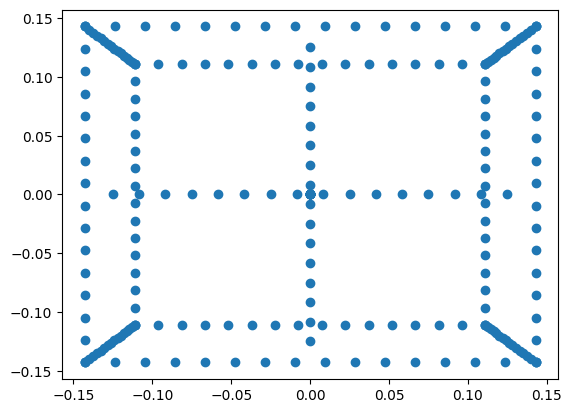

In [43]:
K = np.eye(3)
R = lambda theta: np.array([[np.cos(theta), 0, np.sin(theta)],
                            [0, 1, 0], 
                            [-np.sin(theta), 0, np.cos(theta)]])
t = np.zeros(3)
t[2] = 4
Q = box3d()

plt.scatter(*Pi(projectpoints(K, R(0), t, Q)))
plt.show()
